# Imoport Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import time
import keras
import math
import json 

from shutil import copy
from PIL import Image

sys.path.insert(1, '../../utils')
#from Nutrition5kDataPrep import prepare_data, create_dataset

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import datasets, layers, models
from keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import sklearn.metrics as sklm

# Load Data

In [ ]:
#drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/Nutrition5k")

Mounted at /content/drive


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    with open(filepath, 'r') as txt:
        paths = [read.strip()+'/rgb.png' for read in txt.readlines()]

    if not os.path.exists(dest):
        os.makedirs(dest)

    for food in paths:
        out = food.split('/')
        dest_name = out[0]+'.png'
        src_path = os.path.join(src,food)
        dest_path = os.path.join(dest,dest_name)

        if (not os.path.exists(dest_path)) and os.path.exists(src_path):
            # print("\nCopying images into ", dest_name)
            copy(os.path.join(src,food), os.path.join(dest,dest_name))

    print("Copying Done!")


def create_dataset(filenames, labels,
                   is_training=True,
                   img_size = 224, channels = 3, batch_size = 256, buffer_size = 1024):
  # 
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
    # Parse and preprocess observations in parallel
    dataset = dataset.map(lambda x, y: parse_function(x, y, img_size=img_size, channels=channels),
                          num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=buffer_size)

    # Batch the data for multiple steps
    dataset = dataset.batch(batch_size=batch_size)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset
    
def parse_function(filename, label, img_size = 224, channels = 3):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.io.decode_png(image_string, channels=channels)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [img_size, img_size])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [ ]:
# Prepare train dataset
print("Creating train data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_train_ids.txt' # directory to rgb_train_ids.txt
src = './data/Nutrition5k/realsense_overhead'                     # directory to images 
dest = './data/Nutrition5k/train_rgb'                             # directory to train_rgb folder
prepare_data(filepath, src, dest)

# Prepare test dataset
print("Creating test data...")
filepath = './data/Nutrition5k/dish_ids/splits/rgb_test_ids.txt' # directory to rgb_test_ids.txt
src = './data/Nutrition5k/realsense_overhead'                    # directory to images 
dest = './data/Nutrition5k/test_rgb'                             # directory to test_rgb folder
prepare_data(filepath, src, dest)

# read specified labels
labels = pd.read_csv('./data/Nutrition5k/176_ingredients/nutrition5k_176_ingr_calorie.csv')#.iloc[: , 1:]
labels = labels.rename(columns={"Unnamed: 0": "dish_id"})
labels['dish_id'] = labels['dish_id'] + '.png'
ingred = labels.iloc[: , 1:].columns

ingredients_with_categories = pd.read_csv("./data/Nutrition5k/176_ingredients/ingredients_with_categories_quantile.csv")
# since there 193 ingredients in the ingredients_with_categories, we want to remove the ingredients that are not in the labels
ingredients_with_categories = ingredients_with_categories[ingredients_with_categories["ingr"].isin(labels.columns)] 

Creating train data...
Copying Done!
Creating test data...
Copying Done!


In [ ]:
#ingredients_with_categories = ingredients_with_categories.reset_index()
ingredients_with_categories["ingr_index"] = range(176)

In [ ]:
ingredients_with_categories

,ingr_index,ingr,id,cal/g,fat(g),carb(g),protein(g),frequency,nonzero_mean,food_category,freq_category,mean_category,cluster_category
0,0,olive oil,161,8.840,1.000,0.000,0.000,1561,41.639315,fat_and_oil,10,7,6
1,1,garlic,122,1.490,0.005,0.330,0.064,947,1.844471,vegetable,10,2,3
2,2,pepper,312,0.400,0.002,0.093,0.020,723,0.553660,condiment_and_sauce,10,1,3
3,3,onions,94,0.400,0.001,0.090,0.011,686,3.026821,vegetable,10,2,5
4,4,lemon juice,520,0.170,0.000,0.056,0.004,572,0.233524,beverage,10,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,sandwiches,273,2.329,0.130,0.179,0.110,5,133.218800,mixed_dish,2,9,8
172,172,chilaquiles,372,1.950,0.120,0.120,0.089,4,256.425000,mixed_dish,2,10,1
173,173,sunflower seeds,364,5.460,0.500,0.150,0.190,4,11.303768,protein,2,4,4
174,174,frozen yogurt,275,1.633,0.059,0.245,0.041,4,154.726750,dairy,2,9,8


In [ ]:
np.array_equal(labels.columns[1:].tolist(), ingredients_with_categories['ingr'].tolist())

True

In [ ]:
label_to_idx = dict()
for idx, v in enumerate(labels.columns[1:]):
  label_to_idx[v] = idx

# Data Preparation

## Add Binary Labels

In [ ]:
def add_binary_labels(ds):
  ingredients = ds.columns[1:]
  ds.columns = [ds.columns[0]] + [col + '_calories' for col in ds.columns[1:]]
  for i in ingredients: 
    col_name = f'{i}_calories'
    binary_col_name = f'{i}_binary'
    threshold = 0 # Change this to your desired threshold
    ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
  return ds

labels = add_binary_labels(labels)

<ipython-input-32-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
<ipython-input-32-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[binary_col_name] = (ds[col_name] > threshold).astype(int)
<ipython-input-32-0527861679b8>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [ ]:
labels

,dish_id,olive oil_calories,garlic_calories,pepper_calories,onions_calories,lemon juice_calories,arugula_calories,parsley_calories,cherry tomatoes_calories,spinach (raw)_calories,...,yogurt_binary,tortilla chips_binary,parsnips_binary,chicken salad_binary,greek salad_binary,sandwiches_binary,chilaquiles_binary,sunflower seeds_binary,frozen yogurt_binary,grapefruit juice_binary
0,dish_1561662216.png,28.673672,3.164916,0.084964,0.682869,0.145110,0.0,0.079170,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,dish_1561662054.png,101.154334,4.480668,0.120286,2.409010,0.511915,0.0,0.279295,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,dish_1562008979.png,6.823110,2.300097,0.154369,0.000000,0.262427,0.0,0.286354,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,dish_1560455030.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.9,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,dish_1558372433.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,dish_1563295334.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3258,dish_1566329234.png,3.600125,0.000000,0.000000,0.814508,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3259,dish_1562691737.png,19.620486,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3260,dish_1558458496.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

#X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
#X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

## Scaling: std-mean 

In [ ]:
# scale labels by std and mean of training ingredients
std_by_label = pd.DataFrame(y_train).describe().iloc[2]
print(std_by_label)
mean_by_label = pd.DataFrame(y_train).describe().iloc[1]
print(mean_by_label)
for idx,i in enumerate(labels.columns[1:176]):
    labels[i] = labels[i].apply(lambda x: (x - mean_by_label[idx]) / std_by_label[idx])

0      37.132144
1       1.447911
2       0.525674
3       2.604437
4       0.165839
         ...    
347     0.042570
348     0.038083
349     0.038083
350     0.026939
351     0.032987
Name: std, Length: 352, dtype: float64
0      20.149177
1       0.550192
2       0.129656
3       0.648579
4       0.043325
         ...    
347     0.001815
348     0.001452
349     0.001452
350     0.000726
351     0.001089
Name: mean, Length: 352, dtype: float64


## Scaling: Min-max

In [ ]:
# min-max normalization
max_by_label = pd.DataFrame(y_train).describe().iloc[-1]
#print(max_by_label)
min_by_label = pd.DataFrame(y_train).describe().iloc[3]
#print(min_by_label)
for idx,i in enumerate(labels.columns[1:11]):
    labels[i] = labels[i].apply(lambda x: (x - min_by_label[idx]) / (max_by_label[idx] - min_by_label[idx]))

In [ ]:
# to calculate relative error, we need std
std_by_label = pd.DataFrame(y_train).describe().iloc[2]

## Active std

In [ ]:
# compute non-zero std for each ingredient
y_train_df = pd.DataFrame(y_train)
# print(y_train_df)
active_std = []
for col in y_train_df.columns[:176]:
    non_zero_values = y_train_df[col][y_train_df[col] > 0]
    std = np.std(non_zero_values,ddof = 1)
    active_std.append(std)

print(active_std)

[44.20547480848497, 2.15802012791128, 0.9826579564473065, 4.95985784670916, 0.32544303527581286, 5.287402321563037, 0.41385847613642707, 6.7206413883061735, 5.596236104590032, 14.678297118588983, 0.5387201511867681, 15.240016955321888, 0.19503449420533342, 2.4124561407795695, 8.447767110859735, 134.5944224828153, 0.259802178718507, 26.660648410161283, 80.30932527517264, 264.2101217678144, 15.23461720493551, 0.37551655498445063, 2.893879268854561, 7.005308392072771, 0.3875716224559359, 16.499497003954794, 10.329284602058289, 9.242787090836961, 39.89415186064556, 9.189048087241021, 24.436537337504642, 77.82375446494228, 85.47125791837841, 17.426286716027118, 21.16725649411661, 49.83253374925034, 8.602699995337883, 34.61862817065273, 0.16290770765144919, 200.50795655078056, 35.80913738361048, 109.19268704196286, 105.38085025143005, 2.172205222300922, 75.70432011116435, 7.1926603817093655, 5.893876392480981, 9.211961602735991, 47.303828472739454, 0.1813821711361781, 0.05686599290071862, 0.

## Split datasets

In [ ]:
# split dataset into train and val
train_dest = './data/Nutrition5k/train_rgb'
test_dest = './data/Nutrition5k/test_rgb'

X_train = [os.path.join(train_dest, img) for img in os.listdir(train_dest)]
X_val = [os.path.join(test_dest, img) for img in os.listdir(test_dest)]

y_train = labels.loc[labels.dish_id.isin(os.listdir(train_dest))]\
                .set_index('dish_id').reindex(os.listdir(train_dest))\
                .to_numpy().tolist()
                

y_val = labels.loc[labels.dish_id.isin(os.listdir(test_dest))]\
                .set_index('dish_id').reindex(os.listdir(test_dest))\
                .to_numpy().tolist()
arr_y_val = np.array(y_val)

nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

# define some params
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

# create datasets
train_ds = create_dataset(X_train, y_train, is_training=True,
                          img_size = IMG_SIZE, channels = CHANNELS,
                          batch_size = BATCH_SIZE,
                          buffer_size = SHUFFLE_BUFFER_SIZE)

val_ds = create_dataset(X_val, y_val,
                        img_size = IMG_SIZE, channels = CHANNELS,
                        batch_size = BATCH_SIZE, buffer_size = SHUFFLE_BUFFER_SIZE)

for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (128, 224, 224, 3)
Shape of labels array: (128, 352)


## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

Text(0.5, 1.0, 'Augmented Image')

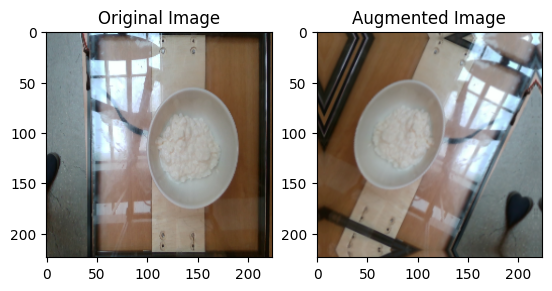

In [ ]:
sample_batch = next(iter(train_ds))
sample_image = sample_batch[0][0]
sample_label = sample_batch[1][0]

plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
augmented_image = data_augmentation(sample_image)
plt.imshow(augmented_image.numpy())
plt.title("Augmented Image")

## Resize image

In [ ]:
# resize the data
#train_ds = train_ds.map(lambda x,y:(data_augmentation(x), y))
train_ds = train_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))
val_ds = val_ds.map(lambda x,y: (tf.image.resize(x, (75,75)),y))

# Classification + Regression

## Metrics

In [ ]:
# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
class self_Accuracy(tf.keras.metrics.Metric):

    def __init__(self, label, value, name='accuracy_by_label_'):
        super(self_Accuracy, self).__init__(name=name)
        self.label = label
        self.value = value
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Called at the end of each batch:
        calculates number of correct prediction and total number of predictions
        """
        # number of correct predictions
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_true_bin = tf.cast(y_true_bin[:,self.label],tf.float32)
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>=0.5,1,0)
        y_pred_bin = tf.cast(y_pred_bin[:,self.label],tf.float32)

        if self.value == "zero":
          indices = tf.where(y_true_bin == 0)
        elif self.value == 'positive':
          indices = tf.where(y_true_bin == 1)
        else:
          indices = []

        if len(indices) != 0:
            y_true_bin = tf.gather(y_true_bin, indices)
            y_pred_bin = tf.gather(y_pred_bin, indices)
            y_true_bin = tf.reshape(y_true_bin, [len(indices)])
            y_pred_bin = tf.reshape(y_pred_bin, [len(indices)])
            self.correct.assign_add(tf.keras.metrics.binary_accuracy(tf.cast(y_true_bin, tf.float32), 
                                tf.cast(y_pred_bin,tf.float32)) 
                                * tf.cast(tf.size(y_pred_bin),tf.float32))                    
        else:
            self.correct.assign_add(tf.keras.metrics.binary_accuracy(tf.cast(y_true_bin,tf.float32), 
                                tf.cast(y_pred_bin,tf.float32)) 
                                * tf.cast(tf.size(y_pred_bin),tf.float32)
                                )
        # total number of predictions 
        self.total.assign_add(tf.cast(tf.size(y_pred_bin),tf.float32))
        
    def result(self):
        return self.correct / self.total
    
    def reset_state(self):
        """
        reset variables between epochs
        """
        self.correct.assign(0)
        self.total.assign(0)


class self_relative_error(tf.keras.metrics.Metric):
    """
    Calculates total MAE for a label.
    NOTE: we need to calculate average later separately
          by dividing total MAE for a label by the number of batches

    """
    def __init__(self, class_id, std, param1, param2, value, scale = "standardization", name='relative_error_by_label_', **kwargs):
        super(self_relative_error, self).__init__(name=name, **kwargs)
        self.scale = scale 
        self.param1 = param1
        self.param2 = param2
        self.value = value
        self.std = std
        self.class_id = class_id
        self.relative_error= self.add_weight(name='relative_error', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_bin = y_true[:, y_true.shape[1]//2:]
        y_pred_logit = y_pred[:, y_true.shape[1]//2:]
        y_pred_prob = tf.nn.sigmoid(y_pred_logit)
        y_pred_bin = tf.where(y_pred_prob>=0.5,1,0)
        # Extract calorie values from y_true
        z_true = y_true[:, :y_true.shape[1]//2]
        z_pred = y_pred[:, :y_true.shape[1]//2]
        if self.scale == "standardization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * self.param1[self.class_id]+self.param2[self.class_id]
        elif self.scale == "normalization":
          z_true = tf.cast(z_true[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32) * (self.param2[self.class_id] - self.param1[self.class_id]) + self.param1[self.class_id]
        else: 
          z_true = tf.cast(z_true[:,self.class_id], tf.float32)
          z_pred = tf.cast(z_pred[:,self.class_id], tf.float32)

        y_pred_bin = tf.cast(y_pred_bin[:,self.class_id], tf.float32)
        z_pred = y_pred_bin * z_pred

        if self.value == "zero":
          indices = tf.where(z_true == 0)
        elif self.value == 'positive':
          indices = tf.where(z_true > 0)
        else:
          indices = []

        active_std = self.std[self.class_id]  
        if len(indices) != 0:
            z_true = tf.gather(z_true, indices)
            z_pred = tf.gather(z_pred, indices)
            z_true = tf.reshape(z_true, [len(indices)])
            z_pred = tf.reshape(z_pred, [len(indices)])
            self.relative_error.assign_add(tf.reduce_mean(
                                          tf.abs(z_true - z_pred)/active_std))                      
        else:
            self.relative_error.assign_add(tf.reduce_mean(
                                          tf.abs(z_true - z_pred)/active_std)) 


    def result(self):
        return self.relative_error

    def reset_state(self):
        self.relative_error.assign(0.)

## Custom Loss function

In [ ]:
def combined_loss_mse(y_true, y_pred):

  z_true = y_true[:, :y_true.shape[1]//2]
  z_pred = y_pred[:, :y_true.shape[1]//2]
  
  y_true_bin = y_true[:, y_true.shape[1]//2:]
  y_pred_logit = y_pred[:, y_true.shape[1]//2:]
  y_pred_prob = tf.nn.sigmoid(y_pred_logit)
  y_pred_bin = tf.where(y_pred_prob>=0.5,1,0)

    # Compute cross-entropy loss
  ce_loss= tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true_bin, logits = y_pred_logit)
  #ce_loss = tf.keras.losses.binary_crossentropy(y_true_bin, y_pred_prob)

    # Compute regression loss only for predicted active ingredients
  #regression_loss = tf.square(z_true - tf.cast(y_pred_bin, tf.float32) * z_pred)  
  regression_loss = tf.cast(y_true_bin, tf.float32) * tf.square(z_true - z_pred)
  # reg_loss = tf.reduce_sum(regression_loss, axis=1)

    # Combine the losses
  loss = tf.reduce_mean(ce_loss) + tf.reduce_mean(regression_loss)
  return loss


## Compile and Fit Model

In [ ]:
input_shape = (75, 75, 3)
num_of_ingre = 176

# Load the InceptionV3 model with pretrained weights
base_model = InceptionV3(weights='imagenet', input_shape = input_shape, include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer for binary classification
binary_preds = Dense(num_of_ingre, name='binary_preds')(x)

# Add a fully-connected layer for regression
regression_preds = Dense(num_of_ingre, name='regression_preds')(x)

combined_preds = Concatenate(name='combined_preds')([binary_preds, regression_preds])

model = Model(inputs=base_model.input, outputs=combined_preds)

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.0001, decay_steps=660)
optimizer_adam_cos_decay = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

# when scale is standardization, param1 is std, param2 is mean
# when scale is normalization, param1 is min, param2 is max
scaling_method = "standardization"
param1 = std_by_label
param2 = mean_by_label

#Compile the model
model.compile(optimizer=optimizer_adam_cos_decay, loss = combined_loss_mse, 
              metrics=[self_Accuracy(label = i, value = "all", name='acc_{}'.format(i)) for i in range(num_of_ingre)]+ 
              [self_Accuracy(label = i, value = "zero", name='non_active_acc_{}'.format(i)) for i in range(num_of_ingre)]+ 
              [self_Accuracy(label = i, value = "positive", name='active_acc_{}'.format(i)) for i in range(num_of_ingre)]+
              [self_relative_error(class_id = i, std = active_std, param1 = param1, param2 = param2, value = "all", scale = scaling_method, name='relative_error_{}'.format(i)) for i in range(num_of_ingre)] + 
              [self_relative_error(class_id = i, std = active_std, param1 = param1, param2 = param2, value = "zero", scale = scaling_method, name='non_active_relative_error_{}'.format(i)) for i in range(num_of_ingre)] + 
              [self_relative_error(class_id = i, std = active_std, param1 = param1, param2 = param2, value = "positive", scale = scaling_method, name='active_relative_error_{}'.format(i)) for i in range(num_of_ingre)]
              )

In [ ]:
EPOCHS = 30
#Train the model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 296s 5s/step - loss: 0.8685 - acc_0: 0.5151 - acc_1: 0.6483 - acc_2: 0.6690 - acc_3: 0.7212 - acc_4: 0.4613 - acc_5: 0.7176 - acc_6: 0.8276 - acc_7: 0.5681 - acc_8: 0.8167 - acc_9: 0.7615 - acc_10: 0.6813 - acc_11: 0.7064 - acc_12: 0.7474 - acc_13: 0.8530 - acc_14: 0.8374 - acc_15: 0.4138 - acc_16: 0.8319 - acc_17: 0.7880 - acc_18: 0.8022 - acc_19: 0.8225 - acc_20: 0.6207 - acc_21: 0.7742 - acc_22: 0.6806 - acc_23: 0.6171 - acc_24: 0.8073 - acc_25: 0.6740 - acc_26: 0.8011 - acc_27: 0.8218 - acc_28: 0.7728 - acc_29: 0.7031 - acc_30: 0.8258 - acc_31: 0.8254 - acc_32: 0.7546 - acc_33: 0.8323 - acc_34: 0.7626 - acc_35: 0.9005 - acc_36: 0.8595 - acc_37: 0.8929 - acc_38: 0.7314 - acc_39: 0.4599 - acc_40: 0.7891 - acc_41: 0.8287 - acc_42: 0.7503 - acc_43: 0.8352 - acc_44: 0.9089 - acc_45: 0.7906 - acc_46: 0.7691 - acc_47: 0.6207 - acc_48: 0.5695 - acc_49: 0.7096 - acc_50: 0.8407 - acc_51: 0.5829 - acc_52: 0.7510 - acc_53: 0.9060 - acc_54: 0.

## Plot Results

In [ ]:
#train_num_of_batch = math.ceil(len(X_train)/BATCH_SIZE)
#val_num_of_batch = math.ceil(len(X_val)/BATCH_SIZE)
train_num_of_batch = len(train_ds)
val_num_of_batch = len(val_ds)
d = history.history
df_new = pd.DataFrame({'epoch':[],'all_accuracy_train':[],'all_accuracy_val':[], 
                       "active_accuracy_train":[], "active_accuracy_val":[], 
                       "non_active_accuracy_train":[], "non_active_accuracy_val":[], 
                       'all_relative_error_train':[], 'all_relative_error_val':[], 'active_relative_error_train':[], 
                       'active_relative_error_val':[], 'non_active_relative_error_train':[], 
                       'non_active_relative_error_val':[], 'loss': [], 'val_loss':[],
                       'label':[]})

for idx in range(num_of_ingre):
    for ep in range(EPOCHS):
        
        acc_train = d['acc_{}'.format(idx)][ep]
        acc_val = d['val_acc_{}'.format(idx)][ep]
        active_acc_train = d['active_acc_{}'.format(idx)][ep]
        active_acc_val = d['val_active_acc_{}'.format(idx)][ep]
        non_active_acc_train = d['non_active_acc_{}'.format(idx)][ep]
        non_active_acc_val = d['val_non_active_acc_{}'.format(idx)][ep]

        all_relative_error_train = d['relative_error_{}'.format(idx)][ep]/train_num_of_batch
        all_relative_error_val = d['val_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        active_relative_error_train = d['active_relative_error_{}'.format(idx)][ep]/train_num_of_batch
        active_relative_error_val = d['val_active_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        non_active_relative_error_train = d['non_active_relative_error_{}'.format(idx)][ep]/train_num_of_batch
        non_active_relative_error_val = d['val_non_active_relative_error_{}'.format(idx)][ep]/val_num_of_batch
        loss_train = d['loss'][ep]
        loss_val = d['val_loss'][ep]

        temp = pd.DataFrame({'epoch':[ep+1],'all_accuracy_train':[acc_train],'all_accuracy_val':[acc_val], 
                             "active_accuracy_train":[active_acc_train], "active_accuracy_val":[active_acc_val], 
                            "non_active_accuracy_train":[non_active_acc_train], "non_active_accuracy_val":[non_active_acc_val],
                             'all_relative_error_train':[all_relative_error_train], 'all_relative_error_val':[all_relative_error_val], 
                             'active_relative_error_train':[active_relative_error_train], 'active_relative_error_val':[active_relative_error_val], 
                             'non_active_relative_error_train':[non_active_relative_error_train], 'non_active_relative_error_val':[non_active_relative_error_val], 
                              'loss': [loss_train], 'val_loss':[loss_val], 'label':[idx]})
        df_new = df_new.append(temp, ignore_index=True)

df_new.label = df_new.label.astype(str)

In [ ]:
df_new

,epoch,all_accuracy_train,all_accuracy_val,active_accuracy_train,active_accuracy_val,non_active_accuracy_train,non_active_accuracy_val,all_relative_error_train,all_relative_error_val,active_relative_error_train,active_relative_error_val,non_active_relative_error_train,non_active_relative_error_val,loss,val_loss,label
0,1.0,0.564791,0.589744,0.618087,0.968610,0.514467,0.292254,0.468292,0.467880,0.808661,0.653134,0.145560,0.323139,0.957686,0.740341,0.0
1,2.0,0.658802,0.601578,0.485800,0.757848,0.822159,0.478873,0.422328,0.441668,0.778003,0.723500,0.084654,0.222472,0.453192,0.700125,0.0
2,3.0,0.714701,0.556213,0.529895,0.950673,0.889203,0.246479,0.398140,0.485367,0.735539,0.615677,0.071642,0.380110,0.257872,0.520827,0.0
3,4.0,0.759710,0.570020,0.634529,0.968610,0.877911,0.257042,0.378374,0.450618,0.696153,0.614147,0.080851,0.318847,0.163662,0.457786,0.0
4,5.0,0.773503,0.664694,0.671151,0.946188,0.870148,0.443662,0.341821,0.396664,0.623910,0.618132,0.075211,0.226555,0.138055,0.400356,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,26.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.068732,0.164513,175.0
5276,27.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.068851,0.164096,175.0
5277,28.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.065716,0.167189,175.0
5278,29.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.067566,0.171317,175.0


In [ ]:
category = "cluster_category"
ing_cat = ingredients_with_categories[["ingr_index", category]]
#print(ing_cat)
df_new['label'] = df_new['label'].astype(float)
merged_df = pd.merge(df_new, ing_cat, left_on='label', right_on = "ingr_index")
#print(merged_df)
mean_values = merged_df.groupby([category, 'epoch'])['all_accuracy_train','all_accuracy_val', 
                                                     "active_accuracy_train", "active_accuracy_val", 
                                                     "non_active_accuracy_train", "non_active_accuracy_val", 
                                                     'all_relative_error_train', 'all_relative_error_val', 
                                                     'active_relative_error_train', 'active_relative_error_val', 
                                                     'non_active_relative_error_train', 'non_active_relative_error_val'].mean().reset_index()
print(mean_values)
mean_values[category] = mean_values[category].astype('category')

     cluster_category  epoch  all_accuracy_train  all_accuracy_val  \
0                   1    1.0            0.795149          0.762776   
1                   1    2.0            0.955519          0.893312   
2                   1    3.0            0.984887          0.974897   
3                   1    4.0            0.988319          0.987807   
4                   1    5.0            0.988319          0.988524   
..                ...    ...                 ...               ...   
265                 9   26.0            0.966969          0.880561   
266                 9   27.0            0.969510          0.880780   
267                 9   28.0            0.970881          0.879027   
268                 9   29.0            0.971486          0.880561   
269                 9   30.0            0.971769          0.879684   

     active_accuracy_train  active_accuracy_val  non_active_accuracy_train  \
0                 0.750537             0.654628                   0.801846   
1  

<ipython-input-59-fe66779df831>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_values = merged_df.groupby([category, 'epoch'])['all_accuracy_train','all_accuracy_val',


In [ ]:
ingredients_with_categories

,ingr_index,ingr,id,cal/g,fat(g),carb(g),protein(g),frequency,nonzero_mean,food_category,freq_category,mean_category,cluster_category
0,0,olive oil,161,8.840,1.000,0.000,0.000,1561,41.639315,fat_and_oil,10,7,6
1,1,garlic,122,1.490,0.005,0.330,0.064,947,1.844471,vegetable,10,2,3
2,2,pepper,312,0.400,0.002,0.093,0.020,723,0.553660,condiment_and_sauce,10,1,3
3,3,onions,94,0.400,0.001,0.090,0.011,686,3.026821,vegetable,10,2,5
4,4,lemon juice,520,0.170,0.000,0.056,0.004,572,0.233524,beverage,10,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,171,sandwiches,273,2.329,0.130,0.179,0.110,5,133.218800,mixed_dish,2,9,8
172,172,chilaquiles,372,1.950,0.120,0.120,0.089,4,256.425000,mixed_dish,2,10,1
173,173,sunflower seeds,364,5.460,0.500,0.150,0.190,4,11.303768,protein,2,4,4
174,174,frozen yogurt,275,1.633,0.059,0.245,0.041,4,154.726750,dairy,2,9,8


In [ ]:
merged_df

,epoch,all_accuracy_train,all_accuracy_val,active_accuracy_train,active_accuracy_val,non_active_accuracy_train,non_active_accuracy_val,all_relative_error_train,all_relative_error_val,active_relative_error_train,active_relative_error_val,non_active_relative_error_train,non_active_relative_error_val,loss,val_loss,label,ingr_index,freq_category
0,1.0,0.564791,0.589744,0.618087,0.968610,0.514467,0.292254,0.468292,0.467880,0.808661,0.653134,0.145560,0.323139,0.957686,0.740341,0.0,0,10
1,2.0,0.658802,0.601578,0.485800,0.757848,0.822159,0.478873,0.422328,0.441668,0.778003,0.723500,0.084654,0.222472,0.453192,0.700125,0.0,0,10
2,3.0,0.714701,0.556213,0.529895,0.950673,0.889203,0.246479,0.398140,0.485367,0.735539,0.615677,0.071642,0.380110,0.257872,0.520827,0.0,0,10
3,4.0,0.759710,0.570020,0.634529,0.968610,0.877911,0.257042,0.378374,0.450618,0.696153,0.614147,0.080851,0.318847,0.163662,0.457786,0.0,0,10
4,5.0,0.773503,0.664694,0.671151,0.946188,0.870148,0.443662,0.341821,0.396664,0.623910,0.618132,0.075211,0.226555,0.138055,0.400356,0.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,26.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.068732,0.164513,175.0,175,1
5276,27.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.068851,0.164096,175.0,175,1
5277,28.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.065716,0.167189,175.0,175,1
5278,29.0,0.998911,1.000000,0.998736,1.000000,1.000000,1.000000,0.196777,0.049183,0.196777,0.049183,0.196777,0.049183,0.067566,0.171317,175.0,175,1


Text(0.5, 1.0, 'Boxplot of Validation Relative Error by Category')

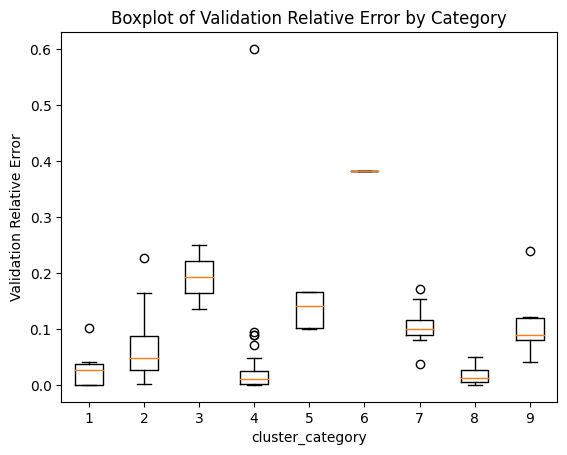

In [ ]:
final_epoch_result = merged_df[merged_df["epoch"] == 30]
grouped_data = final_epoch_result.groupby(category)['all_relative_error_val'].apply(list)
data = grouped_data.values.tolist()
plt.boxplot(data)
plt.xlabel(category)
plt.ylabel('Validation Relative Error')
plt.title('Boxplot of Validation Relative Error by Category')

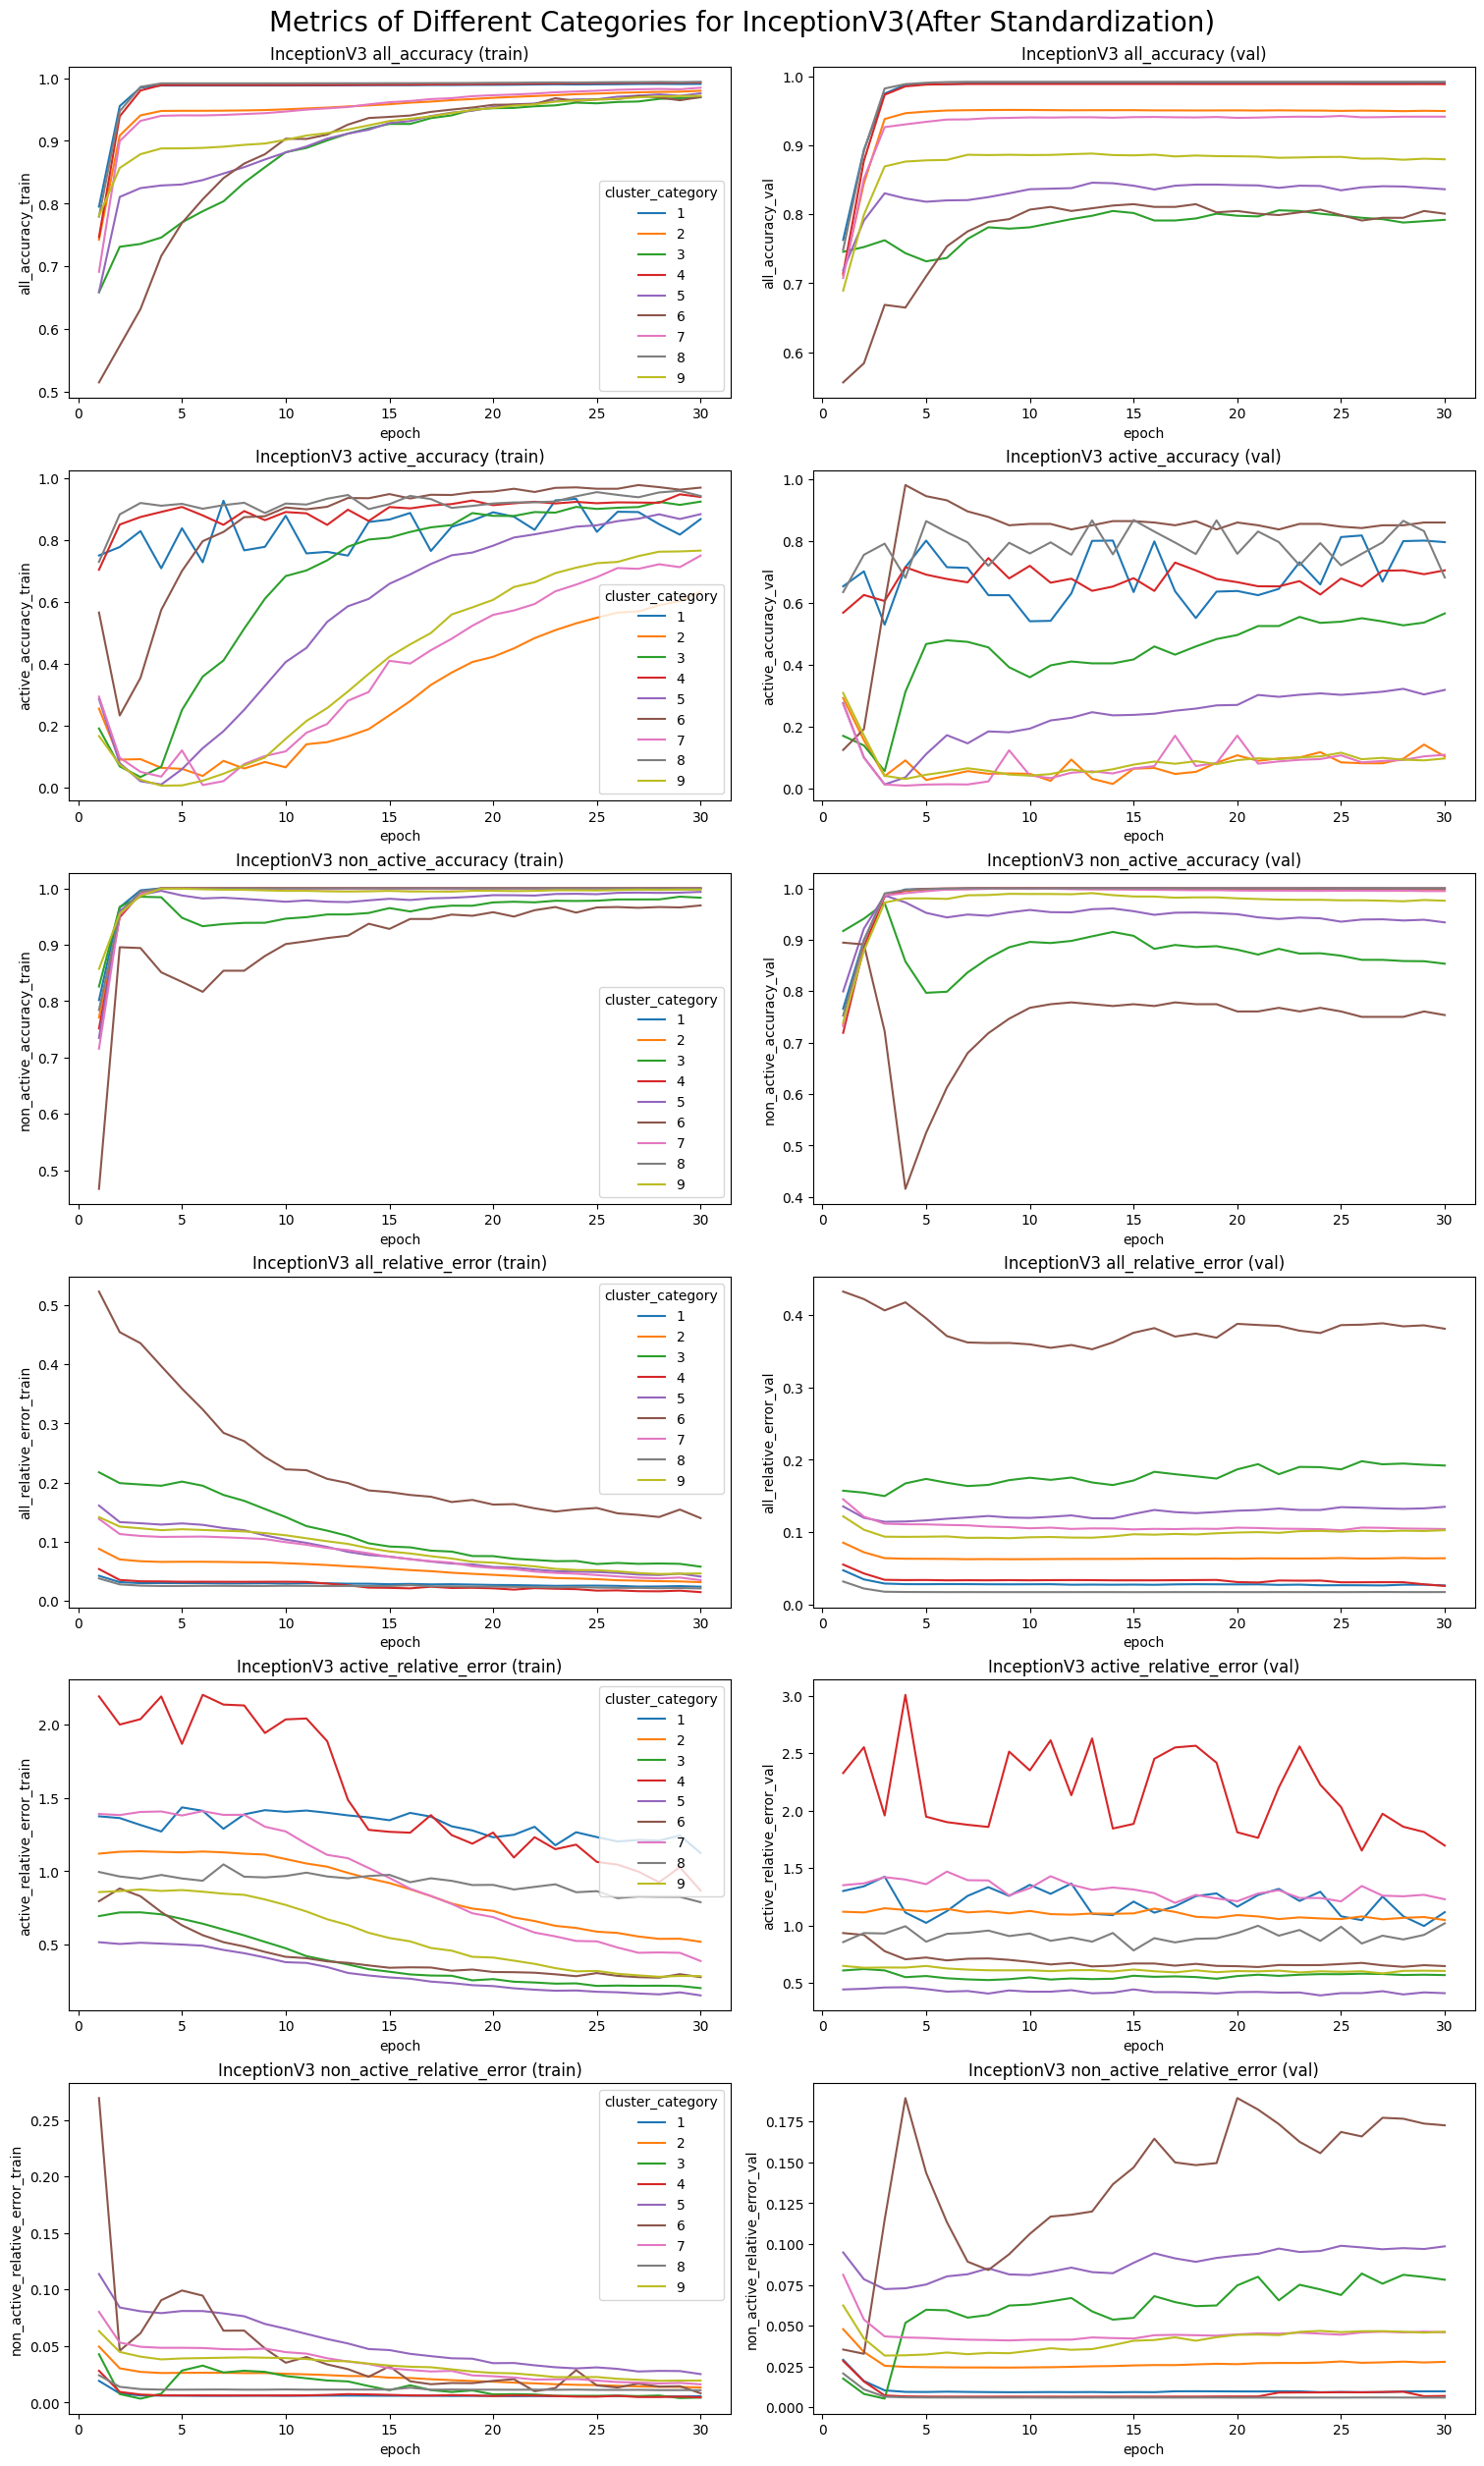

In [ ]:
import seaborn as sns
fig, axis = plt.subplots(6, 2, figsize=(15, 25), constrained_layout = True)
metrics = ['all_accuracy', "active_accuracy", "non_active_accuracy", "all_relative_error", "active_relative_error", "non_active_relative_error"]
datasets = ['train', 'val']
for i in range(6):
    for j in range(2):
        if j == 1:
            sns.lineplot(data=mean_values, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=False, hue=category, ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))
        else:
            sns.lineplot(data=mean_values, x="epoch", y="{}_{}".format(metrics[i], datasets[j]), legend=True, hue=category, ax=axis[i,j])\
                .set(title='InceptionV3 {} ({})'.format(metrics[i], datasets[j]))

fig.suptitle('Metrics of Different Categories for InceptionV3(After Standardization)', fontsize=20);

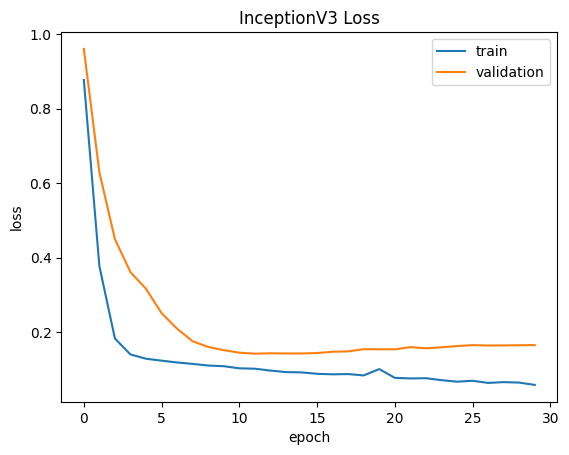

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

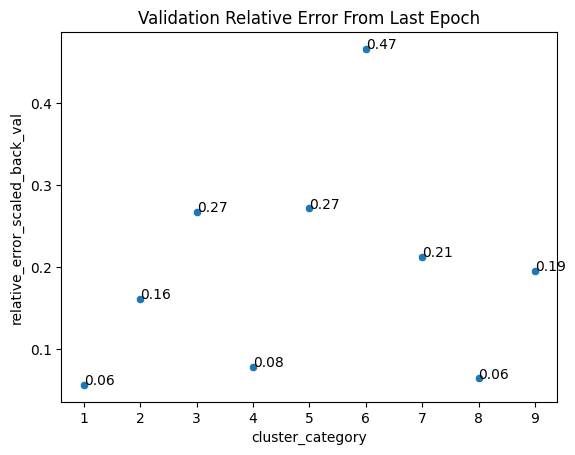

In [ ]:
selected_df = mean_values[mean_values['epoch'] == EPOCHS]
sns.scatterplot(data=selected_df, x=category, y="relative_error_scaled_back_val")
for index, row in selected_df.iterrows():
    plt.text(row[category], row["relative_error_scaled_back_val"], str(round(row["relative_error_scaled_back_val"],2)))
plt.title('Validation Relative Error From Last Epoch')
#plt.xticks(rotation=90)
plt.show()

In [ ]:
df_new

,epoch,accuracy_train,accuracy_val,mse_train,mse_val,mae_train,mae_val,mse_scaled_back_train,mse_scaled_back_val,mae_scaled_back_train,mae_scaled_back_val,relative_error_train,relative_error_val,relative_error_scaled_back_train,relative_error_scaled_back_val,loss,val_loss,label
0,1.0,0.590200,0.631164,1.046495,1.009769,0.668991,0.662578,1615.392756,1480.303101,19.638024,18.405207,0.018016,0.017844,0.528869,0.495668,1.713954,1.714139,0.0
1,2.0,0.697641,0.733728,1.030502,0.962862,0.684106,0.686837,1474.553445,1215.215576,18.789949,19.310432,0.018424,0.018497,0.506029,0.520046,1.395989,1.525002,0.0
2,3.0,0.761162,0.767258,0.927267,0.917936,0.655294,0.672503,1232.936435,1142.467896,16.846186,17.863125,0.017648,0.018111,0.453682,0.481069,1.333323,1.453682,0.0
3,4.0,0.801815,0.788955,0.875247,0.849304,0.634760,0.641888,1126.789151,1062.443970,15.798599,16.131630,0.017095,0.017287,0.425470,0.434438,1.321286,1.355283,0.0
4,5.0,0.822142,0.783037,0.822824,0.856554,0.615528,0.650522,1041.781161,1084.327881,14.938108,16.244190,0.016577,0.017519,0.402296,0.437470,1.312967,1.322308,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5785,26.0,0.999637,1.000000,3.477833,0.000000,0.035143,0.000000,12.369170,0.001290,0.102181,0.035921,0.018639,0.000000,0.054195,0.019052,1.169927,1.277105,192.0
5786,27.0,0.999637,1.000000,3.477833,0.000000,0.035143,0.000000,12.369173,0.001290,0.102181,0.035921,0.018639,0.000000,0.054195,0.019052,1.168043,1.277525,192.0
5787,28.0,0.999637,1.000000,3.477833,0.000000,0.035143,0.000000,12.369173,0.001290,0.102181,0.035921,0.018639,0.000000,0.054195,0.019052,1.168110,1.277964,192.0
5788,29.0,0.999637,1.000000,3.477833,0.000000,0.035143,0.000000,12.369178,0.001290,0.102181,0.035921,0.018639,0.000000,0.054195,0.019052,1.168306,1.276950,192.0


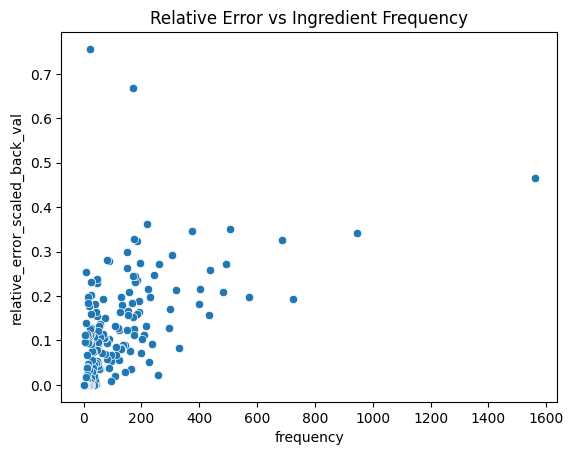

In [ ]:
#ing_cat2 = ingredients_with_categories[["ingr_index", "frequency", "ingr", "food_category"]]
#print(ing_cat)
df_new['label'] = df_new['label'].astype(float)
merged_df2 = pd.merge(df_new, ingredients_with_categories, left_on='label', right_on = "ingr_index")
#print(merged_df2)


sns.scatterplot(data=merged_df2[merged_df2["epoch"]==30], x='frequency', y='relative_error_scaled_back_val')
plt.title("Relative Error vs Ingredient Frequency")
# Show the plot
plt.show()

In [ ]:
df2 = merged_df2[merged_df2["epoch"]==30]
df2 = df2[["relative_error_scaled_back_val", "ingr", "frequency", "food_category", "freq_category", "mean_category", "cluster_category"]]
df2.to_csv('relative_error_vs_frequency.csv', index=False)

In [ ]:
df2[df2["food_category"] == "fat_and_oil"]

,relative_error_scaled_back_val,ingr,frequency,food_category,freq_category,mean_category,cluster_category
29,0.46607,olive oil,1561,fat_and_oil,10,6,6
4889,0.00000,vegetable oil,8,fat_and_oil,2,10,1
